A first pass at writing a machine learning algorithm from scratch to distinguish digits.

First step will be using logistic regression and gradient descent to distinguish between 2 numbers.

In [333]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

Data comes from Kaggle's digit rec playground challenge. https://www.kaggle.com/c/digit-recognizer

I'll import the training set into a pandas dataframe:

In [107]:
df=pd.read_csv('train.csv')

Before doing anything else, let me just look at what I have.

In [64]:
df.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It would be cool to reconstruct the images of the numbers based on the pixel values. I don't know how to do that right now, however, so I'll skip that and go straight to looking at the data's basic stats.

(if you have done this, you should let me know how!)

In [65]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [129]:
df.loc[:,'label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

The useful information I got from the above is that there are no blank spots in the data that need to be worried about and each number is roughly equally represented.

<b>Next, I'm going to do something terrible.</b>

As a first pass on this data, I'm going to throw out almost all the information in the training set. I'm going to set any pixel with a value over 0 equal to 1. In this manner, I'll be able to count how many pixels have some intensity value in every image. My theory is some numbers will have less coverage than others, and I can use that to distinguish between digits with logistic regression.

In [118]:
df[df.iloc[:,1:]>0]=1

Now, I'll create a new column for the total number of activated pixels in each row.

In [131]:
df['total']=df.sum(axis=1)

The moment of truth. I'll look at each digit and see if the total number of activated pixels can be used to seperate the numbers.

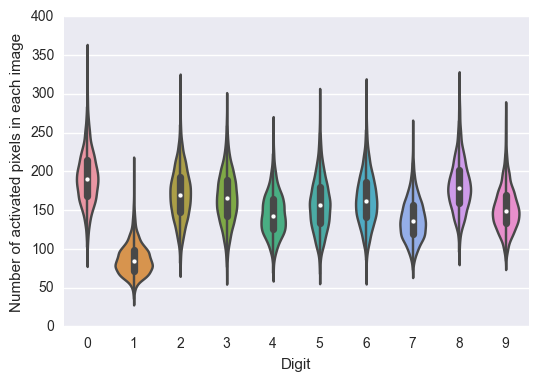

In [365]:
sns.violinplot(x='label',y='total',data=df);
plt.ylabel('Number of activated pixels in each image');
plt.xlabel('Digit');

As you can see, this will be a terrible method for separating the numbers.

Except for 1. So let's do that, as an example of logistic regression. 

For ease, I'll create a new pandas dataframe. It will only have 2 numbers: 0 and 1, and will have just 2 columns: the label demarking the digit and the total number of activated pixels.

In [343]:
dfSub=df.loc[(df.loc[:,'label']==0)|(df.loc[:,'label']==1),['label','total']]
dfSub.reset_index(inplace=True)
del dfSub['index']

And let me reset the total number of activated pixels to live in a range from zero to 1. This is needed for the way I'll calculate how close my logistic function is to the 'real' labels.

In [344]:
dfSub['total']=dfSub['total']/dfSub['total'].max()

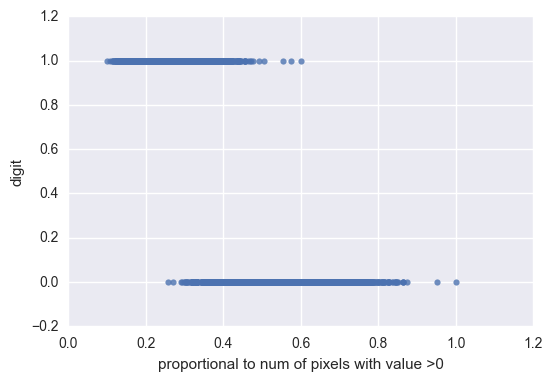

In [366]:
sns.regplot(x='total',y='label',data=dfSub,fit_reg=False);
plt.ylabel('digit');
plt.xlabel('proportional to num of pixels with value >0');

So above I can see that the number 0 has more activiated pixels than the number 1, on overage. I'll now fit a logistic function to this using gradient descent.

Let me first write the logistic (or sigmoid) function. It has 2 parameters, sharpness and center location.

In [274]:
def sigmoid(z, sharp,center):
    g=1/(1+np.exp((z-center)*sharp));
    return g

Next, let me just plot it against the data so it becomes clear what it will do.

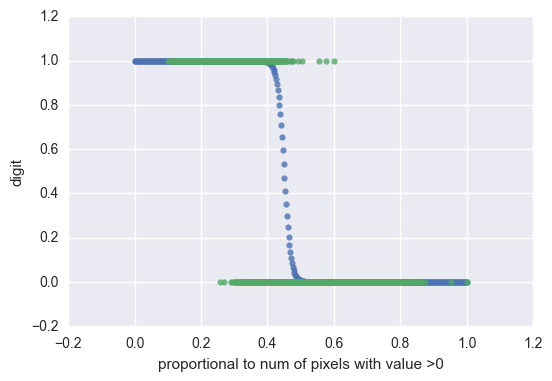

In [360]:
X=np.linspace(0,1,400);
sns.regplot(x=X,y=sigmoid(X,100,.45),fit_reg=False);
sns.regplot(x='total',y='label',data=dfSub,fit_reg=False);
plt.ylabel('digit');
plt.xlabel('proportional to num of pixels with value >0');

The sigmoid function mimics the data's distribution. What our machine learning algorithm will do is find the optimum center for this function such that the difference between the values of all the data points and the values of the sigmoid in minimized.

I could probably also add in a step to find the optimum sharpness of the sigmoid, but I won't bother. For a large range of sharpnesses, the same center is found. And the center is what I really care about.

## And here is the Machine Learning part of this notebook:

In [355]:
c=.7; #initial center. Deliberately chosen away from expected final location to demonstrate ML
C=20; #chosen sharpness value
alpha=.00001; #step size for each step of gradient descent
CF=[]; #cost function record
for x in range(0,100): #the gradient descent section. Currently just running 100 steps, but should have a shutoff funt
    loss=sigmoid(dfSub['total'],C,c)-dfSub['label']; #Find the difference between the 'real' values of 0 or 1 
                                                     #and the returned value from the sigmoid function.
    c=c-alpha*np.dot((sigmoid(dfSub.loc[:,'total'],20,c)-dfSub['label']),dfSub['total'])
    #update the center of the sigmoid function in such a way that it tracks to the minimum value.
    j=dfSub['label']*np.log(sigmoid(dfSub['total'],C,c))+(1-dfSub['label'])*np.log(1-sigmoid(dfSub['total'],C,c));
    #j=calculate the cost function
    CF.append(-np.sum(j)) #append the cost function value to CF
print("And the optimum center for the sigmoid is %s"%(c))

And the optimum center for the sigmoid is 0.376114035701


I saved the cost function values from each run of the gradient descent for loop. Let me plot those to convince myself I've found a (local) best fit.

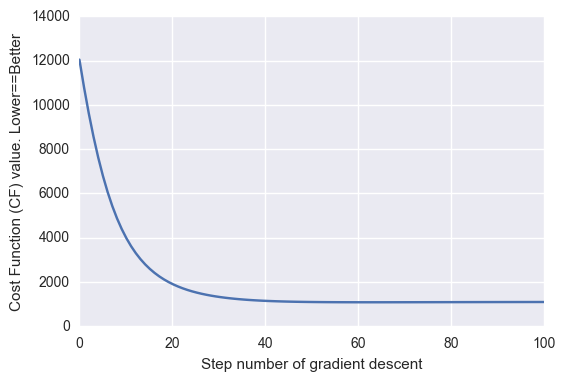

In [357]:
plt.plot(list(np.linspace(0,len(CF),len(CF))),CF)
plt.ylabel('Cost Function (CF) value. Lower==Better')
plt.xlabel('Step number of gradient descent')

I can now plot the optimum sigmoid function against the data:

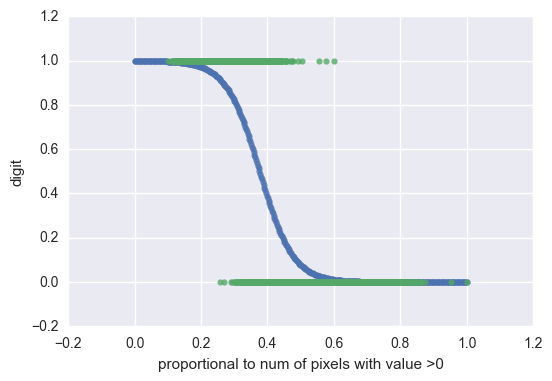

In [361]:
X=np.linspace(0,1,400)
sns.regplot(x=X,y=sigmoid(X,C,c),fit_reg=False)
sns.regplot(x='total',y='label',data=dfSub,fit_reg=False);
plt.ylabel('digit');
plt.xlabel('proportional to num of pixels with value >0');

And most importantly, I can see how many of the training set this would correctly identify.

In [362]:
dfSub['LR Predict']=0;
dfSub.loc[dfSub['total']<c,'LR Predict']=1
print(len(dfSub.loc[dfSub['label']==dfSub['LR Predict'],:])/len(dfSub))

0.9715290381125227


97% success rate is not bad. Of course, there is much more work still to be done.